In [1]:
import ionerdss as ion

pdb_id = '8y7s' # PDB ID for the structure of interest, or the full path to a PDB file
save_folder = '~/Documents/8y7s_dir' # the working directory

# create the PDBModel object using the PDBModel class
pdb_model = ion.PDBModel(pdb_id=pdb_id, save_dir=save_folder)

# coarse grain each chain of the PDB structure to a NERDSS molecule
# set standard_output=True to see the determined interfaces
pdb_model.coarse_grain(
    distance_cutoff=0.35,
    residue_cutoff=3,
    show_coarse_grained_structure=False,
    save_pymol_script=False,
    standard_output=False
    )

# regularize homologous chains to the same NERDSS molecule type
pdb_model.regularize_homologous_chains(
    dist_threshold_intra=3.5,
    dist_threshold_inter=3.5,
    angle_threshold=25.0,
    show_coarse_grained_structure=False,
    save_pymol_script=True,
    standard_output=False
    )

Successfully downloaded assembly file: /Users/sikao/Documents/8y7s_dir/8y7s-assembly1.cif.gz
Homologous chains identified using sequence alignment:
{'B': 'A', 'A': 'A', 'F': 'A', 'E': 'A'}
Homologous chain groups identified:
[['A', 'B', 'E', 'F']]
Regularized coarse-grained structure saved to /Users/sikao/Documents/8y7s_dir/regularized_coarse_grained_structure.cif.
PyMOL script saved to /Users/sikao/Documents/8y7s_dir/visualize_regularized_coarse_grained.pml.
Model saved successfully to /Users/sikao/Documents/8y7s_dir/8y7s_model.json


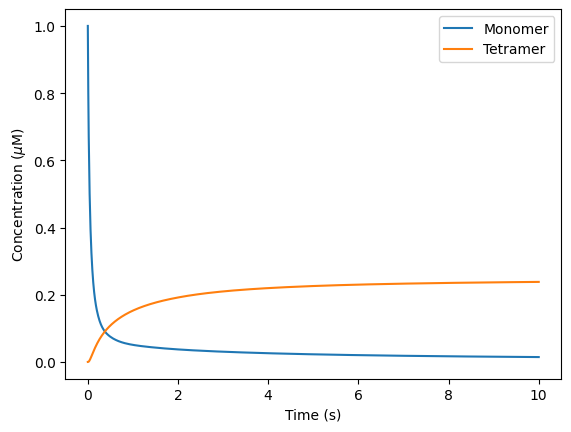

In [2]:
from ionerdss import ParseComplexes
from ionerdss import ReactionStringParser
from ionerdss import solve_reaction_ode, reaction_dydt
import numpy as np

complex_list, complex_reaction_system = ParseComplexes(pdb_model)

# initialize an instance of reaction_string_parser
rsp = ReactionStringParser()

reaction_strings = [reaction.expression for reaction in complex_reaction_system.reactions]
species_names, rate_constant_names, reactant_matrix, product_matrix = rsp.parse_reaction_strings(reaction_strings)

# Rate constant assuming already non-dimensionalized
rate_constants = [reaction.rate for reaction in complex_reaction_system.reactions]

# Define time span and initial concentration, assuming already non-dimensionalized
t_span = [0.0, 10.0]
y_init = np.zeros(len(complex_list)) # initial concentration
y_init[0] = 1.0 # initial monomer concentration

time, concentrations, species_names = solve_reaction_ode(
    reaction_dydt, t_span,  y_init, reactant_matrix = reactant_matrix, product_matrix = product_matrix,
    k = rate_constants, plotting=False, method = "BDF", species_names = species_names
    )

import matplotlib.pyplot as plt

plt.plot(time,((concentrations.T)[0]).T, label='Monomer')
# Plotting the concentrations of Tetramer, sum of 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24
indices = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24]
plt.plot(time,((concentrations.T)[indices]).T.sum(axis=1), label='Tetramer')
plt.xlabel('Time (s)')
plt.ylabel(r'Concentration $\left(\mu\mathrm{M}\right)$')
plt.legend()

In [11]:
# create the Simulation object using the Simulation class
# the simulation is connected to the PDBModel object created above
simulation = ion.Simulation(pdb_model, save_folder)

# generate the NERDSS input files for the simulation
simulation.generate_nerdss_input()

simulation.modify_inp_file(
    {'nItr': 20000000, 'timeStep': 0.5,
    'timeWrite': 20000, 'trajWrite': 2000000,
    'pdbWrite': 2000000, 'A': 130,
    'WaterBox': [600.0, 600.0, 600.0]}
    )

simulation.print_inp_file()

# install NERDSS if not already installed
simulation.install_nerdss(nerdss_path="~/Documents/8y7s_dir")

# run the NERDSS simulation
simulation.run_new_simulations(
    sim_indices=[1],
    sim_dir="~/Documents/8y7s_dir/nerdss_output",
    nerdss_dir="~/Documents/8y7s_dir/NERDSS",
    parallel=False
    )

Working directory set to: /Users/sikao/Documents/8y7s_dir
start parameters
	nItr = 20000000
	timeStep = 0.5
	timeWrite = 20000
	trajWrite = 2000000
	pdbWrite = 2000000
	restartWrite = 100000
	checkPoint = 100000
	transitionWrite = 100000
	clusterOverlapCheck = false
	scaleMaxDisplace = 100.0
	overlapSepLimit = 0.1
end parameters

start boundaries
	WaterBox = [600.0, 600.0, 600.0]
	hasCompartment = false
	compartmentR = 0
	compartmentSiteD = 0
	compartmentSiteRho = 0
	WaterBox = [600.0, 600.0, 600.0]
end boundaries

start molecules
	A : 130
end molecules

start reactions
	A(A1) + A(A1) <-> A(A1!1).A(A1!1)
		onRate3Dka = 10.0
		offRatekb = 0.06022000000000001
		sigma = 0.4976063370704651
		norm1 = [0, 0, 1]
		norm2 = [0, 0, 1]
		assocAngles = [2.529535, 2.558964, 0.772629, 0.752813, 0.969038]
		length3Dto2D = 2.0
		bindRadSameCom = 1.5
		loopCoopFactor = 1.0
		excludeVolumeBound = False

	A(A2) + A(A2) <-> A(A2!1).A(A2!1)
		onRate3Dka = 10.0
		offRatekb = 0.7336297863135685
		sigma = 0.7

Cloning into '/Users/sikao/Documents/8y7s_dir/NERDSS'...
==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
To reinstall 2.8, run:
  brew reinstall gsl


Compiling src/boundary_conditions/check_if_spans_box.cpp to obj/boundary_conditions/check_if_spans_box.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/boundary_conditions/check_if_spans_box.cpp -o obj/boundary_conditions/check_if_spans_box.o  
------------
Compiling src/boundary_conditions/check_if_spans_sphere.cpp to obj/boundary_conditions/check_if_spans_sphere.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/boundary_conditions/check_if_spans_sphere.cpp -o obj/boundary_conditions/check_if_spans_sphere.o  
------------
Compiling src/boundary_conditions/check_if_spans.cpp to obj/boundary_conditions/check_if_spans.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/boundary_conditions/check_if_spans.cpp -o obj/boundary_conditions/check_if_spans.o  
------------
Compiling src/boundary_conditions/reflect_complex_compartment.cpp to obj/boundary_conditions/reflect_complex_compartment.o
g++ -O3  -std=c++

src/math/rand_gsl.cpp:45:18: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   45 |   char charArray[rngFileName.size() + 1];
      |                  ^~~~~~~~~~~~~~~~~~~~~~
src/math/rand_gsl.cpp:45:30: note: non-constexpr function 'size' cannot be used in a constant expression
   45 |   char charArray[rngFileName.size() + 1];
      |                              ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1/string:1284:65: note: declared here
 1284 |   _LIBCPP_HIDE_FROM_ABI _LIBCPP_CONSTEXPR_SINCE_CXX20 size_type size() const _NOEXCEPT {
      |                                                                 ^
src/math/rand_gsl.cpp:105:18: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
  105 |   char charArray[rngFileName.size() + 1];
      |                  ^~~~~~~~~~~~~~~~~~~~~~
src/math/rand_gsl.cpp:105:30: note: non-constexpr function 'size' cannot be used in a constant expression
 

------------
Compiling src/parser/areSameExceptState.cpp to obj/parser/areSameExceptState.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/parser/areSameExceptState.cpp -o obj/parser/areSameExceptState.o  
------------
Compiling src/parser/check_for_state_change.cpp to obj/parser/check_for_state_change.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/parser/check_for_state_change.cpp -o obj/parser/check_for_state_change.o  
------------
Compiling src/parser/check_for_valid_states.cpp to obj/parser/check_for_valid_states.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/parser/check_for_valid_states.cpp -o obj/parser/check_for_valid_states.o  
------------
Compiling src/parser/create_conjugate_reaction_itrs.cpp to obj/parser/create_conjugate_reaction_itrs.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/parser/create_conjugate_reaction_itrs.cpp -o obj/parser/create_conj

src/trajectory_functions/sweep_separation_complex_rot_box.cpp:35:19: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   35 |     int ifaceList[maxRows * com1Size];
      |                   ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_box.cpp:35:19: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_rot_box.cpp:29:9: note: declared here
   29 |     int maxRows { 1 };
      |         ^
src/trajectory_functions/sweep_separation_complex_rot_box.cpp:36:21: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   36 |     int overlapList[maxRows * com1Size];
      |                     ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_box.cpp:36:21: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_rot_box.cpp:29:9:

------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_fiber_box.cpp to obj/trajectory_functions/sweep_separation_complex_rot_fiber_box.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot_fiber_box.cpp -o obj/trajectory_functions/sweep_separation_complex_rot_fiber_box.o  


src/trajectory_functions/sweep_separation_complex_rot_fiber_box.cpp:43:17: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   43 |   int ifaceList[maxRows * com1Size];
      |                 ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_fiber_box.cpp:43:17: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_rot_fiber_box.cpp:37:7: note: declared here
   37 |   int maxRows{1};
      |       ^
src/trajectory_functions/sweep_separation_complex_rot_fiber_box.cpp:44:19: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   44 |   int overlapList[maxRows * com1Size];
      |                   ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_fiber_box.cpp:44:19: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_ro

------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_fiber.cpp to obj/trajectory_functions/sweep_separation_complex_rot_fiber.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot_fiber.cpp -o obj/trajectory_functions/sweep_separation_complex_rot_fiber.o  
------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_memtest_box.cpp to obj/trajectory_functions/sweep_separation_complex_rot_memtest_box.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot_memtest_box.cpp -o obj/trajectory_functions/sweep_separation_complex_rot_memtest_box.o  


src/trajectory_functions/sweep_separation_complex_rot_memtest_box.cpp:34:19: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   34 |     int ifaceList[maxRows * com1Size];
      |                   ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_memtest_box.cpp:34:19: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_rot_memtest_box.cpp:28:9: note: declared here
   28 |     int maxRows { 1 };
      |         ^
src/trajectory_functions/sweep_separation_complex_rot_memtest_box.cpp:35:21: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   35 |     int overlapList[maxRows * com1Size];
      |                     ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_memtest_box.cpp:35:21: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sw

------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_box.cpp to obj/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_box.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_box.cpp -o obj/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_box.o  
------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_sphere.cpp to obj/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_sphere.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_sphere.cpp -o obj/trajectory_functions/sweep_separation_complex_rot_memtest_cluster_sphere.o  
------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_memtest_cluster.cpp to obj/trajectory_functions/sweep_separation_complex_rot_memtest_cl

src/trajectory_functions/sweep_separation_complex_rot_memtest_sphere.cpp:46:19: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   46 |     int ifaceList[maxRows * com1Size];
      |                   ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_memtest_sphere.cpp:46:19: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_rot_memtest_sphere.cpp:40:9: note: declared here
   40 |     int maxRows { 1 };
      |         ^
src/trajectory_functions/sweep_separation_complex_rot_memtest_sphere.cpp:47:21: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   47 |     int overlapList[maxRows * com1Size];
      |                     ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_memtest_sphere.cpp:47:21: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajecto

------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_memtest.cpp to obj/trajectory_functions/sweep_separation_complex_rot_memtest.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot_memtest.cpp -o obj/trajectory_functions/sweep_separation_complex_rot_memtest.o  
------------
Compiling src/trajectory_functions/sweep_separation_complex_rot_sphere.cpp to obj/trajectory_functions/sweep_separation_complex_rot_sphere.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot_sphere.cpp -o obj/trajectory_functions/sweep_separation_complex_rot_sphere.o  


src/trajectory_functions/sweep_separation_complex_rot_sphere.cpp:34:19: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   34 |     int ifaceList[maxRows * com1Size];
      |                   ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_sphere.cpp:34:19: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_rot_sphere.cpp:28:9: note: declared here
   28 |     int maxRows { 1 };
      |         ^
src/trajectory_functions/sweep_separation_complex_rot_sphere.cpp:35:21: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   35 |     int overlapList[maxRows * com1Size];
      |                     ^~~~~~~~~~~~~~~~~~
src/trajectory_functions/sweep_separation_complex_rot_sphere.cpp:35:21: note: read of non-const variable 'maxRows' is not allowed in a constant expression
src/trajectory_functions/sweep_separation_complex_ro

------------
Compiling src/trajectory_functions/sweep_separation_complex_rot.cpp to obj/trajectory_functions/sweep_separation_complex_rot.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/trajectory_functions/sweep_separation_complex_rot.cpp -o obj/trajectory_functions/sweep_separation_complex_rot.o  
------------
Compiling src/io/eye_candy.cpp to obj/io/eye_candy.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/io/eye_candy.cpp -o obj/io/eye_candy.o  
------------
Compiling src/io/init_counterCopyNums.cpp to obj/io/init_counterCopyNums.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/io/init_counterCopyNums.cpp -o obj/io/init_counterCopyNums.o  
------------
Compiling src/io/init_NboundPairs.cpp to obj/io/init_NboundPairs.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/io/init_NboundPairs.cpp -o obj/io/init_NboundPairs.o  
------------
Compiling src/io/init_print_dim

src/io/print_dimers.cpp:20:17: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   20 |     double mult[nTypes];
      |                 ^~~~~~
src/io/print_dimers.cpp:20:17: note: read of non-const variable 'nTypes' is not allowed in a constant expression
src/io/print_dimers.cpp:18:9: note: declared here
   18 |     int nTypes = params.numMolTypes;
      |         ^
src/io/print_dimers.cpp:94:18: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   94 |     int monomers[nTypes];
      |                  ^~~~~~
src/io/print_dimers.cpp:94:18: note: read of non-const variable 'nTypes' is not allowed in a constant expression
src/io/print_dimers.cpp:18:9: note: declared here
   18 |     int nTypes = params.numMolTypes;
      |         ^
src/io/print_dimers.cpp:95:16: warning: variable length arrays in C++ are a Clang extension [-Wvla-cxx-extension]
   95 |     int dimers[nTypes];
      |                ^~~~~~
src/io/print_d

------------
Compiling src/io/print_system_information.cpp to obj/io/print_system_information.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/io/print_system_information.cpp -o obj/io/print_system_information.o  
------------
Compiling src/io/read_restart.cpp to obj/io/read_restart.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/io/read_restart.cpp -o obj/io/read_restart.o  
------------
Compiling src/io/write_all_species.cpp to obj/io/write_all_species.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/io/write_all_species.cpp -o obj/io/write_all_species.o  
------------
Compiling src/io/write_complex_components.cpp to obj/io/write_complex_components.o
g++ -O3  -std=c++0x -I/opt/homebrew/Cellar/gsl/2.8/include -Iinclude  -c src/io/write_complex_components.cpp -o obj/io/write_complex_components.o  
------------
Compiling src/io/write_complex_crds.cpp to obj/io/write_complex_crds.o
g++ -O3  -std=c+

Simulation 1:   0%|          | 0/100 [15:31<?, ?it/s]

All simulations completed.


Detected a batch of 1 simulation directories.
Plotting line with:
- x-axis: time
- y-axis: count
- z-axis: None
- Simulations: 1 selected
- Legend: ['A: 1.', 'A: 4.']
- Display mode: average
Processed data saved to /Users/sikao/Documents/8y7s_dir/nerdss_output/figure_plot_data/complex_count_vs_time.csv
Plot saved to /Users/sikao/Documents/8y7s_dir/nerdss_output/figure_plot_data/complex_count_vs_time.svg


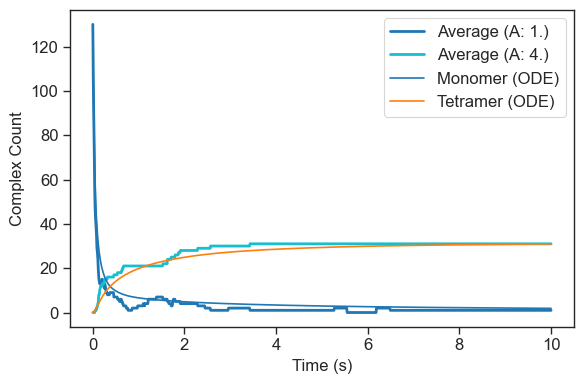

In [5]:
# create the Analysis object using the Analysis class
# the nerdss_output directory is the output directory from the NERDSS simulation
# it can be the parent directory of several simulations
analysis = ion.Analysis("~/Documents/8y7s_dir/nerdss_output")

analysis.plot_figure(
    figure_type='line',
    x='time',
    y='count',
    legend=["A: 1.", "A: 4.",],
    show_type='average',
    figure_size = (6, 4)
    )

plt.plot(time,((concentrations.T)[0]).T * 130, label='Monomer (ODE)')
# Plotting the concentrations of Tetramer, sum of 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24
indices = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24]
plt.plot(time,((concentrations.T)[indices]).T.sum(axis=1) * 130, label='Tetramer (ODE)')

plt.legend()